## Check global mean wind velocities

In [1]:
import warnings
from pathlib import Path

import iris
import iris.pandas
import matplotlib.pyplot as plt

In [2]:
from aeolus.coord import get_cube_rel_days
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import PLANETS, SUITES
from util_mypaths import path_to_data_umserve, path_to_results
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
use_paper_style()

In [5]:
# Parameters
metallicity = "solar"

In [6]:
# Process data
vrbls = {}
for planet in PLANETS.keys():
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        # Load data
        fpath = SUITES[planet][exp][metallicity]["dir_for_merged"]
        fname = f"{SUITES[planet][exp][metallicity]['suite']}.nc"
        u = iris.load_cube(str(fpath / fname), um.u)
        v = iris.load_cube(str(fpath / fname), um.v)
        w = iris.load_cube(str(fpath / fname), um.w) * 100  # scaled for plotting
        # Calculate max zonal, meridional and vertical wind velocity
        u_max = u.collapsed(["level_height", "latitude", "longitude"], iris.analysis.MAX)
        v_max = v.collapsed(["level_height", "latitude", "longitude"], iris.analysis.MAX)
        w_max = w.collapsed(["level_height", "latitude", "longitude"], iris.analysis.MAX)
        # Find number of simulation days since the first model output on day 10
        time_in_rel_days = get_cube_rel_days(u, model=um) + 10
        # Assemble data
        vrbls[planet][exp] = {
            "time_in_rel_days": time_in_rel_days,
            "u_max": u_max,
            "v_max": v_max,
            "w_max": w_max,
        }

In [7]:
# Print final values
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        print(
            planet,
            exp,
            vrbls[planet][exp]["u_max"][-1].data / 1e3,
            vrbls[planet][exp]["v_max"][-1].data / 1e3,
            vrbls[planet][exp]["w_max"][-1].data / 1e5,
        )

hatp11b equilibrium 2.7368279976840943 1.5656055446124117 0.005415835579638826
hatp11b kinetics 2.581057502908272 1.3662594953656977 0.005183685320183699
hd189733b equilibrium 6.890070997359516 3.5230267849558787 0.01251742662004036
hd189733b kinetics 6.961628392682583 3.4070318172055396 0.011218615729714419
hd209458b equilibrium 6.532993398255651 2.7566160956306494 0.021678784518486437
hd209458b kinetics 6.531129711678294 2.7252441430314382 0.022089566459000586
wasp17b equilibrium 6.908711797912309 2.5089788040386476 0.04929688033783497
wasp17b kinetics 6.908285134066601 2.5091506790970137 0.049282691994353


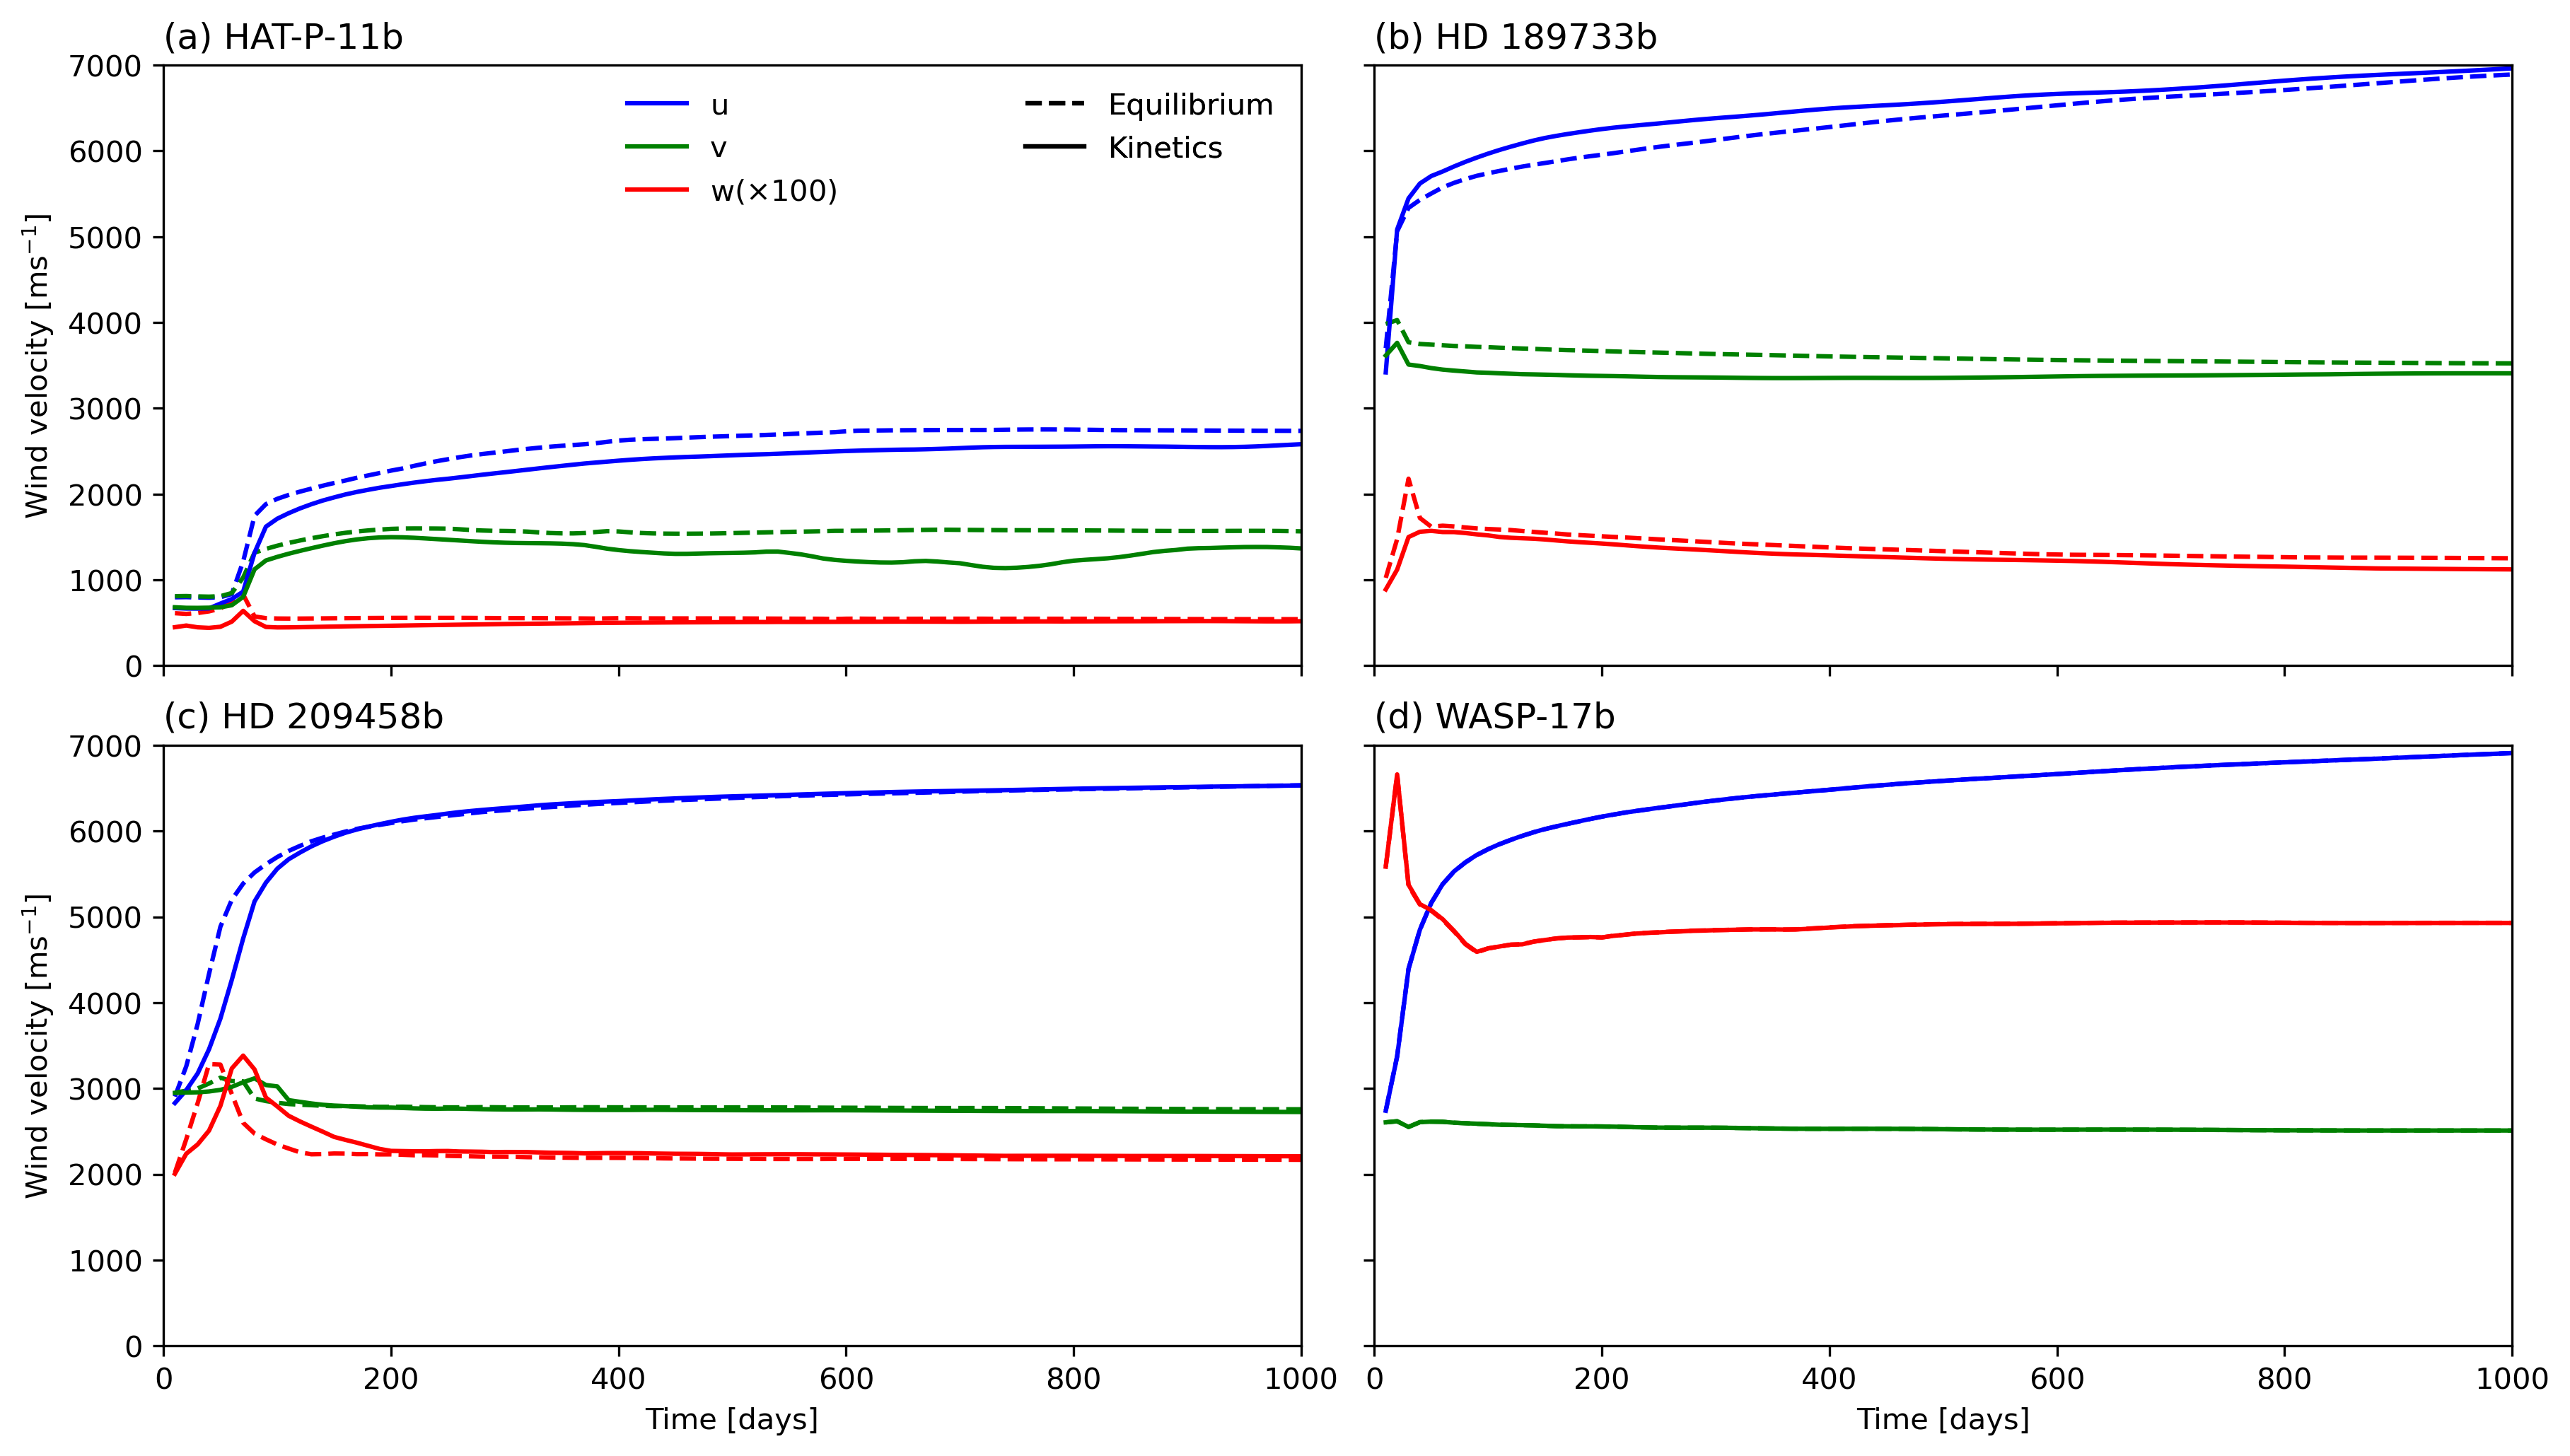

In [8]:
# Plot wind velocities vs time
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(12, 6.75), sharex=True, sharey=True, constrained_layout=True
)
iletters = subplot_label_generator()
for planet, iax in zip(PLANETS.keys(), ax.flatten()):
    iax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    for exp, linestyle in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        iax.plot(
            vrbls[planet][exp]["time_in_rel_days"],
            vrbls[planet][exp]["u_max"].data,
            color="b",
            linestyle=linestyle,
        )
        iax.plot(
            vrbls[planet][exp]["time_in_rel_days"],
            vrbls[planet][exp]["v_max"].data,
            color="g",
            linestyle=linestyle,
        )
        iax.plot(
            vrbls[planet][exp]["time_in_rel_days"],
            vrbls[planet][exp]["w_max"].data,
            color="r",
            linestyle=linestyle,
        )
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel("Wind velocity [m$s^{-1}$]")
        if iax.get_subplotspec().is_first_row():
            add_custom_legend(
                iax,
                {"u": {"color": "b"}, "v": {"color": "g"}, r"w($\times100$)": {"color": "r"}},
                frameon=False,
                loc="upper center",
            )
            add_custom_legend(
                iax,
                {
                    "equilibrium".capitalize(): {"linestyle": "dashed", "color": "k"},
                    "kinetics".capitalize(): {"linestyle": "solid", "color": "k"},
                },
                frameon=False,
                loc="upper right",
            )
for iax in ax.flatten():
    if iax.get_subplotspec().is_last_row():
        iax.set_xlabel("Time [days]")
    iax.set_xlim(0, 1000)
    iax.set_ylim(0, 7000)
figname = f"steady_state_ts_wind_max.png"
fig.savefig(path_to_results / "steady_state" / figname)

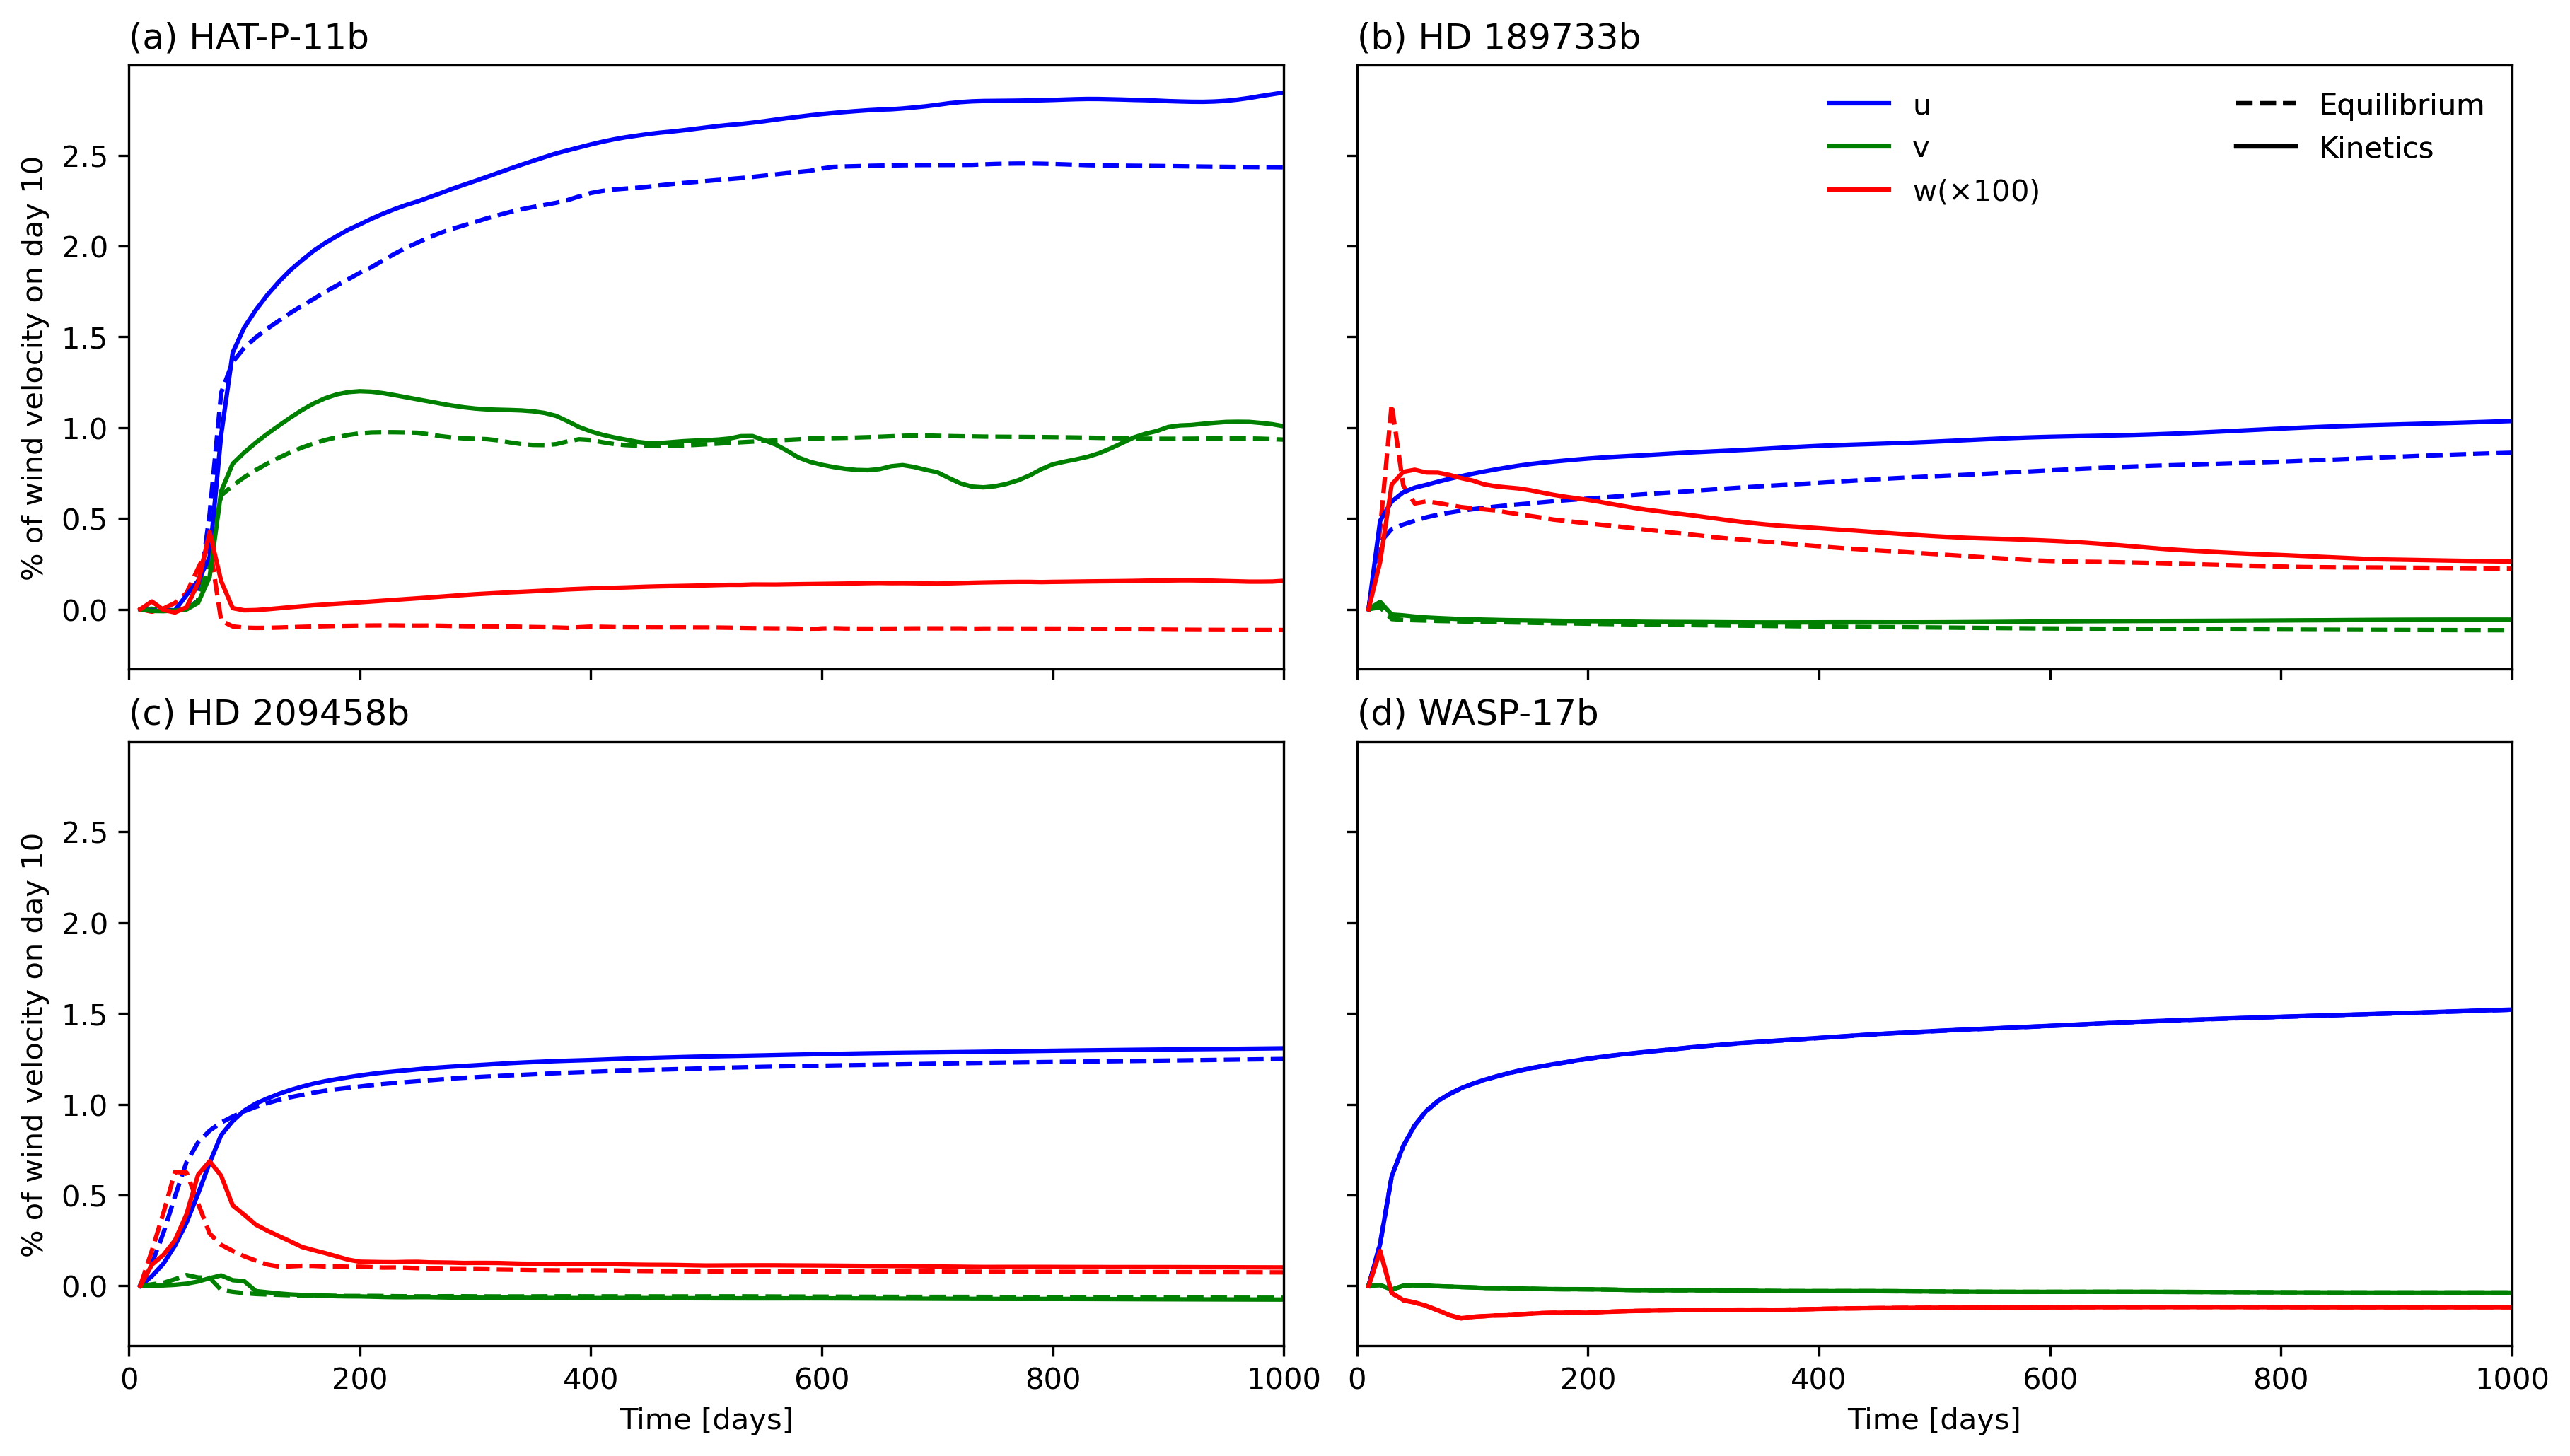

In [9]:
# Plot % change in wind velocities starting on day 10 vs time
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(12, 6.75), sharex=True, sharey=True, constrained_layout=True
)
iletters = subplot_label_generator()
for planet, iax in zip(PLANETS.keys(), ax.flatten()):
    iax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    for exp, linestyle in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        iax.plot(
            vrbls[planet][exp]["time_in_rel_days"],
            iris.pandas.as_series(vrbls[planet][exp]["u_max"], copy=True)
            .pct_change()
            .fillna(0)
            .add(1)
            .cumprod()
            .sub(1),
            color="b",
            linestyle=linestyle,
        )
        iax.plot(
            vrbls[planet][exp]["time_in_rel_days"],
            iris.pandas.as_series(vrbls[planet][exp]["v_max"], copy=True)
            .pct_change()
            .fillna(0)
            .add(1)
            .cumprod()
            .sub(1),
            color="g",
            linestyle=linestyle,
        )
        iax.plot(
            vrbls[planet][exp]["time_in_rel_days"],
            iris.pandas.as_series(vrbls[planet][exp]["w_max"], copy=True)
            .pct_change()
            .fillna(0)
            .add(1)
            .cumprod()
            .sub(1),
            color="r",
            linestyle=linestyle,
        )
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel("% of wind velocity on day 10")
    else:
        if iax.get_subplotspec().is_first_row():
            add_custom_legend(
                iax,
                {"u": {"color": "b"}, "v": {"color": "g"}, r"w($\times100$)": {"color": "r"}},
                frameon=False,
                loc="upper center",
            )
            add_custom_legend(
                iax,
                {
                    "equilibrium".capitalize(): {"linestyle": "dashed", "color": "k"},
                    "kinetics".capitalize(): {"linestyle": "solid", "color": "k"},
                },
                frameon=False,
                loc="upper right",
            )
for iax in ax.flatten():
    if iax.get_subplotspec().is_last_row():
        iax.set_xlabel("Time [days]")
    iax.set_xlim(0, 1000)
figname = f"steady_state_ts_wind_max_pct_of_initial.png"
fig.savefig(path_to_results / "steady_state" / figname)